In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.bouncing_ball import bouncing_ball, bouncing_ball_data, bouncing_ball_plots

from combinators.inference import GuidedConditioning
from combinators.inference import importance, mcmc
from combinators.model import foldable
import combinators.utils as utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [6]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [7]:
num_particles = (100,)

In [8]:
init_bouncing_ball = bouncing_ball.InitBouncingBall(batch_shape=num_particles)

In [9]:
bouncing_ball_step = bouncing_ball.BouncingBallStep(batch_shape=num_particles)

In [10]:
def proposal_step():
    return bouncing_ball.ProposalStep(batch_shape=num_particles, name='BouncingBallStep')

In [11]:
prior_init_params = {
    'position_0': {
        'loc': torch.zeros(2),
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'loc': {
            'loc': torch.ones(2),
            'scale': torch.ones(2),
        },
        'cov': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [12]:
variational_init_params = {
    'position_0': {
        'loc': torch.zeros(2),
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'loc': {
            'loc': torch.ones(2),
            'scale': torch.ones(2),
        },
        'cov': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [13]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['displacement_%d' % i] = displacements[i-1]
    
    return trajectory, displacements, data

In [14]:
def accumulate_trajectory(inference):
    result = torch.zeros(num_particles[0], len(trajectory), 2)
    result[:, 0] = inference['Reduce/Foldable(0)/InitBouncingBall']['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce/Foldable(%d)/BouncingBallStep' % t]['displacement_%d' % (t+1)].value
    return result

In [15]:
def graph_position_trajectory(positions, T, s):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    plt.savefig('position_trajectory_%d.pdf' % s)

In [16]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [17]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [18]:
def generative_model(data, params):
    params['position_0']['loc'] = data['position_0']
    init_bouncing_ball = bouncing_ball.InitBouncingBall(params=params, trainable=False, batch_shape=num_particles)
    return importance.reduce_smc(bouncing_ball_step, lambda: range(T), initializer=init_bouncing_ball)

In [19]:
def proposal_model(data, params):
    params['position_0']['loc'] = data['position_0']
    init_proposal = bouncing_ball.InitBouncingBall(params=params, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Foldable(proposal_step(), initializer=init_proposal), lambda: range(T))

In [20]:
def posterior_model(data, params, step_proposal):
    generative_params = prior_init_params.copy()
    generative_params['position_0']['loc'] = data['position_0']
    
    generative_init = bouncing_ball.InitBouncingBall(params=generative_params, trainable=False,
                                                     batch_shape=num_particles)
    params['position_0']['loc'] = data['position_0']
    proposal_init = bouncing_ball.InitBouncingBall(params=params, trainable=False, batch_shape=num_particles)
    init_posterior = GuidedConditioning(generative_init, proposal_init)
    
    step_posterior = GuidedConditioning(bouncing_ball_step, step_proposal)
    
    return mcmc.reduce_resample_move_smc(step_posterior, lambda: range(T), initializer=init_posterior)

02/20/2019 15:41:46 EUBO=-3.92913116e+02 at epoch 1
02/20/2019 15:41:47 EUBO=-4.53413208e+02 at epoch 2
02/20/2019 15:41:48 EUBO=1.33704544e+02 at epoch 3
02/20/2019 15:41:49 EUBO=-6.09276367e+03 at epoch 4
02/20/2019 15:41:49 EUBO=2.62932205e+01 at epoch 5
02/20/2019 15:41:50 EUBO=-1.17698374e+01 at epoch 6
02/20/2019 15:41:51 EUBO=-2.27229175e+03 at epoch 7
02/20/2019 15:41:52 EUBO=-1.71811816e+03 at epoch 8
02/20/2019 15:41:52 EUBO=-1.32652185e+03 at epoch 9
02/20/2019 15:41:53 EUBO=-8.83771133e+01 at epoch 10
02/20/2019 15:41:54 EUBO=-9.77677917e+02 at epoch 11
02/20/2019 15:41:55 EUBO=1.04967270e+02 at epoch 12
02/20/2019 15:41:55 EUBO=-1.19506826e+04 at epoch 13
02/20/2019 15:41:56 EUBO=-4.11615430e+03 at epoch 14
02/20/2019 15:41:57 EUBO=-6.34436646e+02 at epoch 15
02/20/2019 15:41:58 EUBO=1.02452934e+02 at epoch 16
02/20/2019 15:41:58 EUBO=-7.53086914e+02 at epoch 17
02/20/2019 15:41:59 EUBO=-1.59352737e+02 at epoch 18
02/20/2019 15:42:00 EUBO=-1.64398239e+02 at epoch 19
02/20/

Epoch   324: reducing learning rate of group 0 to 5.0000e-02.


02/20/2019 15:45:53 EUBO=-2.54305603e+02 at epoch 326
02/20/2019 15:45:54 EUBO=-5.09641228e+01 at epoch 327
02/20/2019 15:45:55 EUBO=-1.69171173e+02 at epoch 328
02/20/2019 15:45:56 EUBO=-7.03580444e+02 at epoch 329
02/20/2019 15:45:56 EUBO=7.14617157e+01 at epoch 330
02/20/2019 15:45:57 EUBO=-7.51378906e+03 at epoch 331
02/20/2019 15:45:58 EUBO=1.99490479e+02 at epoch 332
02/20/2019 15:45:59 EUBO=-8.44846420e+01 at epoch 333
02/20/2019 15:45:59 EUBO=3.43135118e+00 at epoch 334
02/20/2019 15:46:00 EUBO=-4.60057129e+02 at epoch 335
02/20/2019 15:46:01 EUBO=-8.28304749e+02 at epoch 336
02/20/2019 15:46:02 EUBO=-4.55210449e+03 at epoch 337
02/20/2019 15:46:02 EUBO=-7.64611084e+03 at epoch 338
02/20/2019 15:46:03 EUBO=4.78329315e+01 at epoch 339
02/20/2019 15:46:04 EUBO=-4.15187744e+02 at epoch 340
02/20/2019 15:46:05 EUBO=-1.04580188e+03 at epoch 341
02/20/2019 15:46:05 EUBO=-1.63971863e+01 at epoch 342
02/20/2019 15:46:06 EUBO=-4.24400732e+03 at epoch 343
02/20/2019 15:46:07 EUBO=-1.3158

Epoch   525: reducing learning rate of group 0 to 2.5000e-02.


02/20/2019 15:48:25 EUBO=-1.35887070e+02 at epoch 527
02/20/2019 15:48:25 EUBO=-1.25328743e+02 at epoch 528
02/20/2019 15:48:26 EUBO=-1.85462463e+03 at epoch 529
02/20/2019 15:48:27 EUBO=-1.07834436e+03 at epoch 530
02/20/2019 15:48:28 EUBO=1.18930492e+01 at epoch 531
02/20/2019 15:48:28 EUBO=-1.84281328e+05 at epoch 532
02/20/2019 15:48:29 EUBO=-3.72810596e+03 at epoch 533
02/20/2019 15:48:30 EUBO=-1.91651215e+02 at epoch 534
02/20/2019 15:48:31 EUBO=-2.18270340e+02 at epoch 535
02/20/2019 15:48:31 EUBO=-3.09890228e+02 at epoch 536
02/20/2019 15:48:32 EUBO=-5.47700488e+03 at epoch 537
02/20/2019 15:48:33 EUBO=1.51987167e+02 at epoch 538
02/20/2019 15:48:33 EUBO=-1.42168365e+02 at epoch 539
02/20/2019 15:48:34 EUBO=3.27227497e+00 at epoch 540
02/20/2019 15:48:35 EUBO=-2.79607666e+02 at epoch 541
02/20/2019 15:48:36 EUBO=5.37420273e+00 at epoch 542
02/20/2019 15:48:36 EUBO=-3.13169556e+01 at epoch 543
02/20/2019 15:48:37 EUBO=-2.03353467e+03 at epoch 544
02/20/2019 15:48:38 EUBO=-1.8119

Epoch   732: reducing learning rate of group 0 to 1.2500e-02.


02/20/2019 15:51:00 EUBO=-8.99788589e+01 at epoch 734
02/20/2019 15:51:01 EUBO=2.54650154e+01 at epoch 735
02/20/2019 15:51:02 EUBO=-6.13067749e+02 at epoch 736
02/20/2019 15:51:02 EUBO=2.26106735e+02 at epoch 737
02/20/2019 15:51:03 EUBO=-1.37405723e+04 at epoch 738
02/20/2019 15:51:04 EUBO=-4.20105553e+01 at epoch 739
02/20/2019 15:51:05 EUBO=1.91646362e+02 at epoch 740
02/20/2019 15:51:05 EUBO=-4.64000671e+02 at epoch 741
02/20/2019 15:51:06 EUBO=-7.11026367e+02 at epoch 742
02/20/2019 15:51:07 EUBO=-3.83016815e+02 at epoch 743
02/20/2019 15:51:08 EUBO=1.22237755e+02 at epoch 744
02/20/2019 15:51:08 EUBO=-1.12953882e+03 at epoch 745
02/20/2019 15:51:09 EUBO=-5.99548279e+02 at epoch 746
02/20/2019 15:51:10 EUBO=2.81225014e+01 at epoch 747
02/20/2019 15:51:11 EUBO=-4.41109521e+03 at epoch 748
02/20/2019 15:51:11 EUBO=6.27068062e+01 at epoch 749
02/20/2019 15:51:12 EUBO=-2.42514328e+02 at epoch 750
02/20/2019 15:51:13 EUBO=-2.76531448e+01 at epoch 751
02/20/2019 15:51:14 EUBO=-1.075818

Epoch   933: reducing learning rate of group 0 to 6.2500e-03.


02/20/2019 15:53:31 EUBO=-6.64309025e+00 at epoch 935
02/20/2019 15:53:32 EUBO=-1.19230298e+03 at epoch 936
02/20/2019 15:53:33 EUBO=1.00087830e+02 at epoch 937
02/20/2019 15:53:33 EUBO=-1.11008766e+02 at epoch 938
02/20/2019 15:53:34 EUBO=-8.08923096e+02 at epoch 939
02/20/2019 15:53:35 EUBO=-1.11301689e+02 at epoch 940
02/20/2019 15:53:36 EUBO=2.59528885e+01 at epoch 941
02/20/2019 15:53:36 EUBO=-1.15459251e+02 at epoch 942
02/20/2019 15:53:37 EUBO=-1.85710828e+03 at epoch 943
02/20/2019 15:53:38 EUBO=8.28540192e+01 at epoch 944
02/20/2019 15:53:39 EUBO=1.80017052e+01 at epoch 945
02/20/2019 15:53:39 EUBO=6.43429031e+01 at epoch 946
02/20/2019 15:53:40 EUBO=3.60318108e+01 at epoch 947
02/20/2019 15:53:41 EUBO=-1.49502319e+03 at epoch 948
02/20/2019 15:53:42 EUBO=-2.87471655e+03 at epoch 949
02/20/2019 15:53:42 EUBO=-5.87899902e+03 at epoch 950
02/20/2019 15:53:43 EUBO=-5.35828308e+02 at epoch 951
02/20/2019 15:53:44 EUBO=-6.86185150e+01 at epoch 952
02/20/2019 15:53:45 EUBO=-2.071256

Epoch  1134: reducing learning rate of group 0 to 3.1250e-03.


02/20/2019 15:56:02 EUBO=-5.73257629e+02 at epoch 1136
02/20/2019 15:56:03 EUBO=-3.20810150e+02 at epoch 1137
02/20/2019 15:56:03 EUBO=2.79349823e+01 at epoch 1138
02/20/2019 15:56:04 EUBO=-6.91367340e+00 at epoch 1139
02/20/2019 15:56:05 EUBO=1.44285803e+01 at epoch 1140
02/20/2019 15:56:06 EUBO=-3.53145966e+02 at epoch 1141
02/20/2019 15:56:06 EUBO=-7.76085083e+02 at epoch 1142
02/20/2019 15:56:07 EUBO=1.26385756e+01 at epoch 1143
02/20/2019 15:56:08 EUBO=-1.65401199e+02 at epoch 1144
02/20/2019 15:56:09 EUBO=-2.74955811e+02 at epoch 1145
02/20/2019 15:56:09 EUBO=-1.09677380e+03 at epoch 1146
02/20/2019 15:56:10 EUBO=1.27339382e+01 at epoch 1147
02/20/2019 15:56:11 EUBO=-5.82589035e+01 at epoch 1148
02/20/2019 15:56:12 EUBO=-5.78959770e+01 at epoch 1149
02/20/2019 15:56:12 EUBO=4.44176197e+00 at epoch 1150
02/20/2019 15:56:13 EUBO=-1.96259918e+01 at epoch 1151
02/20/2019 15:56:14 EUBO=-3.06156006e+01 at epoch 1152
02/20/2019 15:56:15 EUBO=-7.16393311e+02 at epoch 1153
02/20/2019 15:5

Epoch  1335: reducing learning rate of group 0 to 1.5625e-03.


02/20/2019 15:58:33 EUBO=-1.39844482e+02 at epoch 1337
02/20/2019 15:58:33 EUBO=-2.42007858e+02 at epoch 1338
02/20/2019 15:58:34 EUBO=-4.53661461e+01 at epoch 1339
02/20/2019 15:58:35 EUBO=1.06178818e+01 at epoch 1340
02/20/2019 15:58:36 EUBO=1.21090225e+02 at epoch 1341
02/20/2019 15:58:36 EUBO=1.72198532e+02 at epoch 1342
02/20/2019 15:58:37 EUBO=1.85946503e+01 at epoch 1343
02/20/2019 15:58:38 EUBO=-1.98492737e+02 at epoch 1344
02/20/2019 15:58:39 EUBO=-6.65495758e+01 at epoch 1345
02/20/2019 15:58:39 EUBO=-3.43757233e+02 at epoch 1346
02/20/2019 15:58:40 EUBO=-6.35362671e+02 at epoch 1347
02/20/2019 15:58:41 EUBO=1.03176277e+02 at epoch 1348
02/20/2019 15:58:41 EUBO=-2.95786157e+03 at epoch 1349
02/20/2019 15:58:42 EUBO=4.64162712e+01 at epoch 1350
02/20/2019 15:58:43 EUBO=-1.06814178e+02 at epoch 1351
02/20/2019 15:58:44 EUBO=-5.38066559e+01 at epoch 1352
02/20/2019 15:58:45 EUBO=-6.00843140e+02 at epoch 1353
02/20/2019 15:58:45 EUBO=7.27265244e+01 at epoch 1354
02/20/2019 15:58:

Epoch  1536: reducing learning rate of group 0 to 7.8125e-04.


02/20/2019 16:01:04 EUBO=-5.91588916e+03 at epoch 1538
02/20/2019 16:01:05 EUBO=-3.57429047e+02 at epoch 1539
02/20/2019 16:01:06 EUBO=-3.08568573e+02 at epoch 1540
02/20/2019 16:01:07 EUBO=1.11861092e+02 at epoch 1541
02/20/2019 16:01:08 EUBO=-1.40040076e+03 at epoch 1542
02/20/2019 16:01:08 EUBO=-2.57595642e+02 at epoch 1543
02/20/2019 16:01:09 EUBO=-1.82007202e+02 at epoch 1544
02/20/2019 16:01:10 EUBO=8.06750717e+01 at epoch 1545
02/20/2019 16:01:11 EUBO=-3.04031738e+02 at epoch 1546
02/20/2019 16:01:11 EUBO=-2.41967102e+02 at epoch 1547
02/20/2019 16:01:12 EUBO=-3.89129295e+01 at epoch 1548
02/20/2019 16:01:13 EUBO=-1.08077461e+04 at epoch 1549
02/20/2019 16:01:14 EUBO=-2.04627167e+02 at epoch 1550
02/20/2019 16:01:15 EUBO=3.95549583e+01 at epoch 1551
02/20/2019 16:01:16 EUBO=-2.11651642e+02 at epoch 1552
02/20/2019 16:01:16 EUBO=-1.58620773e+02 at epoch 1553
02/20/2019 16:01:17 EUBO=-4.85772278e+02 at epoch 1554
02/20/2019 16:01:18 EUBO=-1.38349731e+02 at epoch 1555
02/20/2019 16

Epoch  1737: reducing learning rate of group 0 to 3.9063e-04.


02/20/2019 16:03:43 EUBO=1.59799149e+02 at epoch 1739
02/20/2019 16:03:44 EUBO=-1.04664574e+01 at epoch 1740
02/20/2019 16:03:45 EUBO=-1.27867407e+03 at epoch 1741
02/20/2019 16:03:45 EUBO=-1.11911011e+03 at epoch 1742
02/20/2019 16:03:46 EUBO=6.17638435e+01 at epoch 1743
02/20/2019 16:03:47 EUBO=6.18831520e+01 at epoch 1744
02/20/2019 16:03:48 EUBO=4.94515839e+01 at epoch 1745
02/20/2019 16:03:49 EUBO=-2.65524048e+03 at epoch 1746
02/20/2019 16:03:49 EUBO=-2.83940399e+02 at epoch 1747
02/20/2019 16:03:50 EUBO=-9.87774277e+01 at epoch 1748
02/20/2019 16:03:51 EUBO=9.03585129e+01 at epoch 1749
02/20/2019 16:03:52 EUBO=-7.67342590e+02 at epoch 1750
02/20/2019 16:03:53 EUBO=-1.04326575e+03 at epoch 1751
02/20/2019 16:03:53 EUBO=-3.18308449e+01 at epoch 1752
02/20/2019 16:03:54 EUBO=-3.44883881e+02 at epoch 1753
02/20/2019 16:03:55 EUBO=2.55884399e+01 at epoch 1754
02/20/2019 16:03:56 EUBO=-2.24804703e+02 at epoch 1755
02/20/2019 16:03:56 EUBO=-1.36862585e+03 at epoch 1756
02/20/2019 16:03

Epoch  1938: reducing learning rate of group 0 to 1.9531e-04.


02/20/2019 16:06:20 EUBO=-1.62017529e+03 at epoch 1940
02/20/2019 16:06:21 EUBO=-5.23444092e+02 at epoch 1941
02/20/2019 16:06:21 EUBO=-3.83583755e+01 at epoch 1942
02/20/2019 16:06:22 EUBO=-5.12427429e+02 at epoch 1943
02/20/2019 16:06:23 EUBO=6.26667099e+01 at epoch 1944
02/20/2019 16:06:24 EUBO=-6.46525146e+02 at epoch 1945
02/20/2019 16:06:24 EUBO=-1.29449023e+03 at epoch 1946
02/20/2019 16:06:25 EUBO=-4.97604248e+02 at epoch 1947
02/20/2019 16:06:26 EUBO=4.69040375e+01 at epoch 1948
02/20/2019 16:06:27 EUBO=-1.18724068e+02 at epoch 1949
02/20/2019 16:06:28 EUBO=-4.31176819e+02 at epoch 1950
02/20/2019 16:06:28 EUBO=-2.81803970e+01 at epoch 1951
02/20/2019 16:06:29 EUBO=4.30540619e+01 at epoch 1952
02/20/2019 16:06:30 EUBO=-5.27180127e+03 at epoch 1953
02/20/2019 16:06:31 EUBO=-1.07287024e+03 at epoch 1954
02/20/2019 16:06:31 EUBO=-4.20079651e+02 at epoch 1955
02/20/2019 16:06:32 EUBO=-4.02316895e+02 at epoch 1956
02/20/2019 16:06:33 EUBO=-4.27667877e+02 at epoch 1957
02/20/2019 16

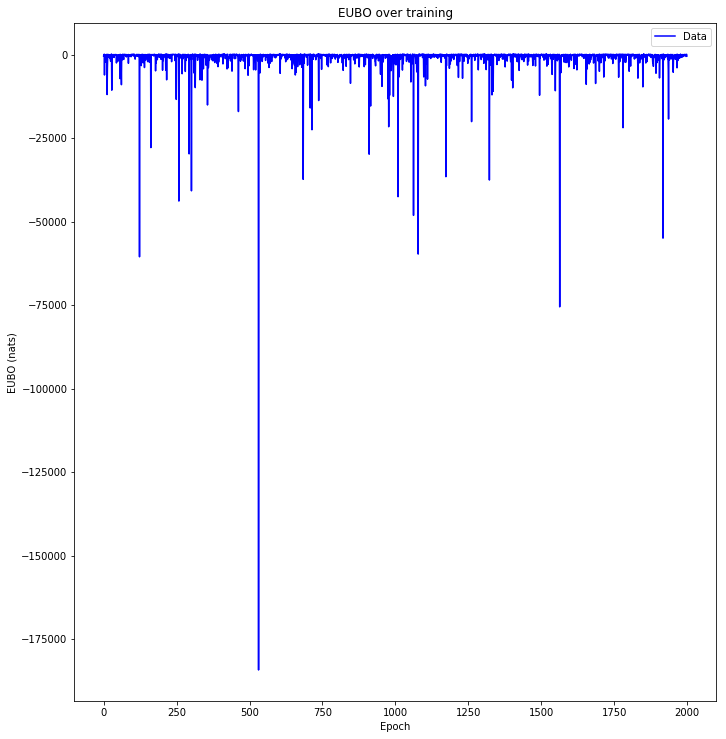

In [ ]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    bouncing_ball_smc = generative_model(data, prior_init_params.copy())
    bouncing_ball_proposal = proposal_model(data, variational_init_params.copy())
    importance_sampler = GuidedConditioning(bouncing_ball_proposal, bouncing_ball_smc)
    
    inference, trained_params, eubos = importance.variational_importance(
        importance_sampler, 2000, data,
        use_cuda=False, lr=1e-1, inclusive_kl=True,
        patience=200,
    )
    utils.plot_evidence_bounds(eubos, False)
    
    bouncing_ball_posterior = posterior_model(data, trained_params, bouncing_ball_proposal.folder.operator)
    (positions, _, A_pred, final_mu, final_cov), inference, _ = bouncing_ball_posterior(data=data)
    As_pred[s] = A_pred.mean(dim=0).detach().numpy()
    final_mus[s] = final_mu.mean(dim=0).detach().numpy()
    final_covs[s] = final_cov.mean(dim=0).detach().numpy()
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory[:, 1:, :].mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Foldable(%d)/BouncingBallStep' % t]['displacement_%d' % (t+1)].value for t in range(T)], dim=1).mean(dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_position_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    modal_directions[s] = bouncing_ball.reflect_directions(trained_params['directions']['loc']['loc'].unsqueeze(0)).squeeze(0)
    
    plt.close('all')

In [ ]:
graph_velocity_frequencies(modal_directions.detach())

In [ ]:
fs = 3 ## figure size
vmax = 0.3 ## cmap maximum value, to make off-diagonal elements more visible
width_space = 0.05 # space between figures
height_space = 0.05 # space between figures
cov_flag = False # plot the covariances or not
legend_flag = False # plot the legend bar or not
save_flag = True ## save or not

In [ ]:
## plot method 1
bouncing_ball_plots.plot_circle_transition(init_v, final_mus, final_covs,
                                           As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

In [ ]:
## plot method 2
bouncing_ball_plots.plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

In [ ]:
def plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag):

    As_infer = As_pred / As_pred.sum(-1)[:, :, None]
    As_infer = As_infer.mean(0)
    As_true_ave = As_true.mean(0)

    fig = plt.figure(figsize=(fs*1.5 + width_space,fs + height_space))
    gs1 = gridspec.GridSpec(1, 1)
    # , width_ratios=[2,1], height_ratios=[1,1]
    gs1.update(left=0.0, bottom=0.0, right=(2/3), top=1.0, wspace=width_space, hspace=height_space)
    ax1 = fig.add_subplot(gs1[0])

    # ax3 = fig.add_subplot(gs[1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])

    gs2 = gridspec.GridSpec(4, 1)
    gs2.update(left=2/3 + (1/3)*width_space, bottom=0.5+(1/2)*width_space, right=1.0, top=1.0, wspace=0, hspace=0)
    ax2 = fig.add_subplot(gs2[0, 0])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs2[1, 0])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs2[2, 0])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs2[3, 0])
    ax5.set_xticks([])
    ax5.set_yticks([])

    gs3 = gridspec.GridSpec(4, 1)
    gs3.update(left=2/3 + (1/3)*width_space, bottom=0.0, right=1.0, top=0.5 - (1/2)*width_space, wspace=0, hspace=0)
    ax6 = fig.add_subplot(gs3[0, 0])
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax7 = fig.add_subplot(gs3[1, 0])
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax8 = fig.add_subplot(gs3[2, 0])
    ax8.set_xticks([])
    ax8.set_yticks([])
    ax9 = fig.add_subplot(gs3[3, 0])
    ax9.set_xticks([])
    ax9.set_yticks([])
    markersize = 10.0
    colors = ['b', 'Purple', 'g', 'r']
    ## plot left one
    ax1.scatter(init_v[:,0], init_v[:,1], s=markersize, color=colors[0], label='z=1')
    ax1.scatter(init_v[:,0], -init_v[:,1], s=markersize, color=colors[1], label='z=2')
    ax1.scatter(-init_v[:,0], -init_v[:,1], s=markersize, color=colors[2], label='z=3')
    ax1.scatter(-init_v[:,0], init_v[:,1], s=markersize, color=colors[3], label='z=4')

    for k in range(K):
        ax1.scatter(final_mus[:,k,0], final_mus[:,k,1], c=colors[k], marker='x')
    if cov_flag:
        for k in range(K):
            for s in range(num_series):
                plot_cov_ellipse(cov=final_covs[s, k, :, :], pos=final_mus[s, k, :], nstd=0.3, ax=ax1, alpha=0.3)
    #    ax1.set_xlabel('x velocity')
    #    ax1.set_ylabel('y velocity')
    if legend_flag:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15), ncol=4)

    ax2.imshow(As_infer[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax3.imshow(As_infer[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax4.imshow(As_infer[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax5.imshow(As_infer[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    ax6.imshow(As_true_ave[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax7.imshow(As_true_ave[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax8.imshow(As_true_ave[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax9.imshow(As_true_ave[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    if save_flag:
        fig.savefig('combinator_results.pdf', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.svg', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.png', dpi=600, bbox_inches='tight')

In [ ]:
## plot method 2
plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)